In [34]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l

根据带有噪声的线性模型构造一个人造数据集，目的是使用这个有限样本的数据集来恢复这个模型的参数。
该数据集使用低维数据，这样可以很容易的将其可视化。
该数据集包含1000个样本，每个样本包含从标准正态分布中采样的2个特征。
符号表达为：X=[1000,2]
线性模型参数设为 w=(  2  、b=4.2和噪声项 c 生成数据集及其标签
                 -3.4)
              c 服从均值为0，标准差为0.01的正态分布
    y = Xw + b + c

In [35]:
def synthetic_data(w,b,num_examples):
    '''
    人工构造一个数据集
    :param w: 权重
    :param b: 偏置值
    :param num_examples:要生成的样本个数
    :return:特征 features 和标签 labels
    '''
    '''
    normal(均值，方差，(x的维度：行，列))，
    此处，行=num_examples，即行数代表着样本个数，列=len(w)，Xw为矩阵乘法，所以 X 的列数= w 的行数
    '''
    x = torch.normal(0,1,(num_examples,len(w)))# normal(均值，方差，(x的维度：行，列))

    # 计算 y
    y = torch.matmul(x,w) + b
    y += torch.normal(0,0.01,y.shape)

    return x,y.reshape((-1,1)) # y 最终的形式是一个列向量

# 定义 w 和 b 的值
true_w = torch.tensor([2,-3.4])
true_b = 4.2
features, labels = synthetic_data(true_w,true_b,1000)


a = torch.ones(4, 4)这是测试的小例子

In [36]:
a = torch.ones(4, 4)
print(a)
# reshape((-1,1))改变矩阵的维度，最终为列向量的形式。
# 行数根据列数来确定，此处列定义为 1 ，则最终为一个列向量
print(a.reshape((-1,1)))
# test_b = torch.tensor([j for j in range(12)]).reshape(3,4)
# print(test_b)
# print(test_b[:,1]) # 取所有行与第 1 列的数据，维度下标从 0 开始

tensor([[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]])


In [37]:
# 输出一下 features 和 labels
print(features.shape,'features:',features[0],'\nlabels:',labels[0])

torch.Size([1000, 2]) features: tensor([-1.9661,  2.2279]) 
labels: tensor([-7.2971])


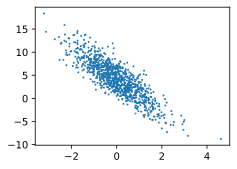

In [38]:
# 使用 d2l 将数据样本可视化
d2l.set_figsize()
d2l.plt.scatter(features[:,1].detach().numpy(),
                labels.detach().numpy(),1)

训练模型时要对数据集进⾏遍历，每次抽取⼀⼩批量样本，并使⽤它们来更新我们的模型。由于
这个过程是训练机器学习算法的基础，所以有必要定义⼀个函数，该函数能打乱数据集中的样本并以⼩批量
⽅式获取数据。

在下⾯的代码中，我们定义⼀个data_iter函数，该函数接收批量⼤⼩、特征矩阵和标签向量作为输⼊，⽣成
⼤⼩为batch_size的⼩批量。每个⼩批量包含⼀组特征和标签。

In [39]:
def data_iter(batch_size,features,labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # 打乱样本索引值列表，将其变成随机无序的
    random.shuffle(indices)
    for i in range(0,num_examples,batch_size):
        batch_indices = torch.tensor(
            indices[i:min(i+batch_size,num_examples)])
        yield features[batch_indices],labels[batch_indices]


初始化模型参数 w ，b

在初始化参数之后，我们的任务是更新这些参数，直到这些参数⾜够拟合我们的数据。每次更新都需要计算
损失函数关于模型参数的梯度。有了这个梯度，我们就可以向减⼩损失的⽅向更新每个参数。

In [40]:
w = torch.normal(0,0.01,size=(2,1),requires_grad=True)
b = torch.zeros(1,requires_grad=True)

定义模型
y = Xw + b
X(1000,2)  w(2,1)  b=常量，利用python的广播机制即可

In [41]:
def linreg(X,w,b):
    '''线性回归模型'''
    return torch.matmul(X,w) + b

定义损失函数
使用平方损失函数

In [42]:
def squared_loss(y_hat, y):
    '''均方损失'''
    return (y_hat-y.reshape(y_hat.shape)) ** 2 / 2

定义优化算法


In [43]:
def sgd(params, lr, batch_size):
    '''
    小批量随机梯度下降
    :param params: 一个 batch_size 的 X 特征和 对应的标签 y所组成的 list列表
    :param lr: 学习率
    :param batch_size: 批量大小
    :return: 无
    '''
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

训练模型

In [44]:
lr = 0.3
num_epochs = 3
net = linreg
loss = squared_loss
batch_size = 10

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)
        l.sum().backward()
        sgd([w, b], lr, batch_size)
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.000054
epoch 2, loss 0.000056
epoch 3, loss 0.000051


In [45]:
print(f'w的估计误差: {true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差: {true_b - b}')

w的估计误差: tensor([-0.0004, -0.0009], grad_fn=<SubBackward0>)
b的估计误差: tensor([0.0011], grad_fn=<RsubBackward1>)
